Dask client dashboard is available at: http://localhost:8778/
Searching NASA Horizons for 'Sun'... 
Found: Sun (10) 
Searching NASA Horizons for 'Jupiter'... 
Found: Jupiter Barycenter (5) (chosen from query 'Jupiter')
Searching NASA Horizons for 'Saturn'... 
Found: Saturn Barycenter (6) (chosen from query 'Saturn')
Searching NASA Horizons for 'Uranus'... 
Found: Uranus Barycenter (7) (chosen from query 'Uranus')
Searching NASA Horizons for 'Neptune'... 
Found: Neptune Barycenter (8) (chosen from query 'Neptune')


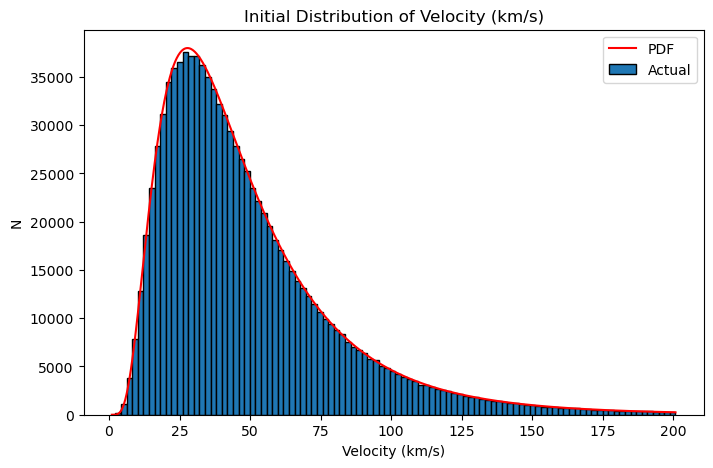

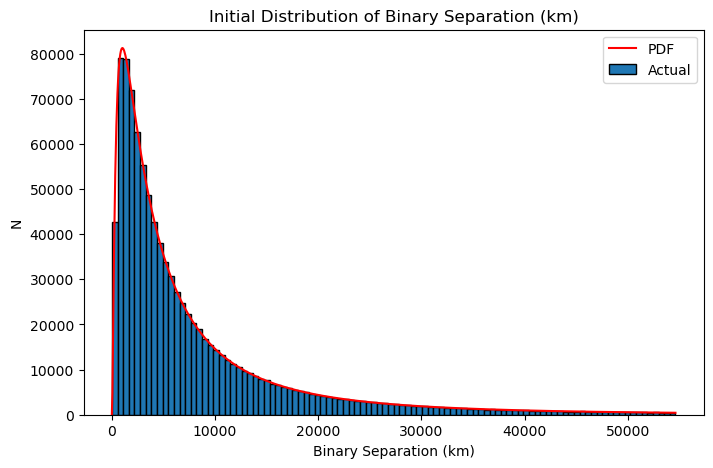

Approximate number bound: 121, or ratio: 0.000121


  0%|          | 0/1000 [00:00<?, ?it/s]/opt/anaconda3/envs/pace/lib/python3.13/site-packages/rebound/simulation.py:259: RuntimeWarning: At least 10 predictor corrector loops in IAS15 did not converge. This is typically an indication of the timestep being too large.
  warnings.warn(msg[1:], RuntimeWarning)
/opt/anaconda3/envs/pace/lib/python3.13/site-packages/rebound/simulation.py:259: RuntimeWarning: At least 10 predictor corrector loops in IAS15 did not converge. This is typically an indication of the timestep being too large.
  warnings.warn(msg[1:], RuntimeWarning)
/opt/anaconda3/envs/pace/lib/python3.13/site-packages/rebound/simulation.py:259: RuntimeWarning: At least 10 predictor corrector loops in IAS15 did not converge. This is typically an indication of the timestep being too large.
  warnings.warn(msg[1:], RuntimeWarning)
/opt/anaconda3/envs/pace/lib/python3.13/site-packages/rebound/simulation.py:259: RuntimeWarning: At least 10 predictor corrector loops in IAS15 did not conv

Actual Number collided: 21191
Number of bound: 86/1000000 or 8.6e-05, 1 bound ISO in 151442.6184195901 years, Theoretical fraction bound: 0.000121
Accuracy: 59.30232558139535


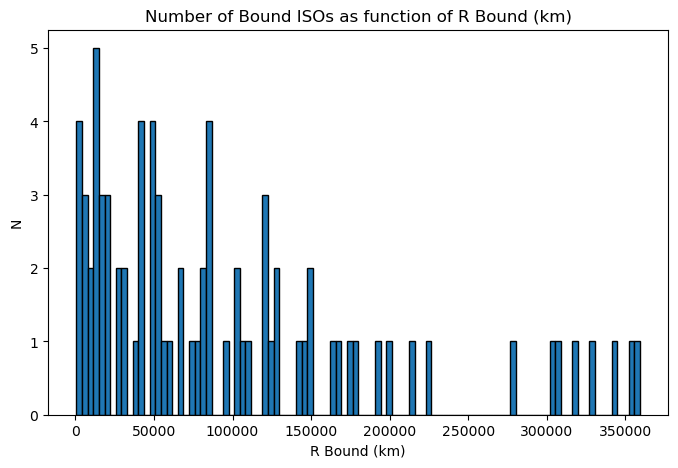

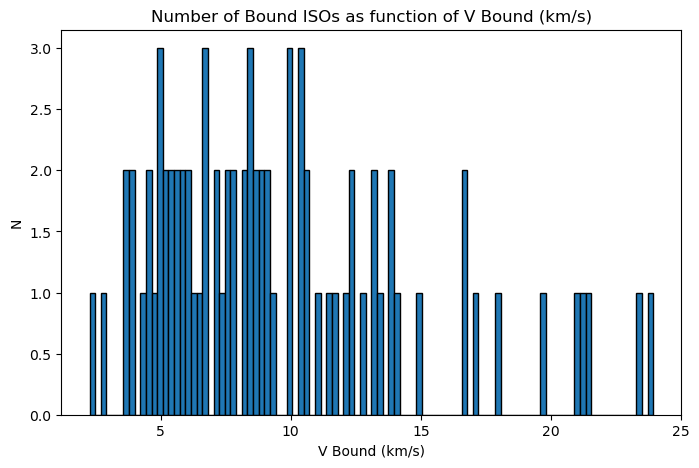

100%|██████████| 22/22 [00:00<00:00, 2652.56it/s]


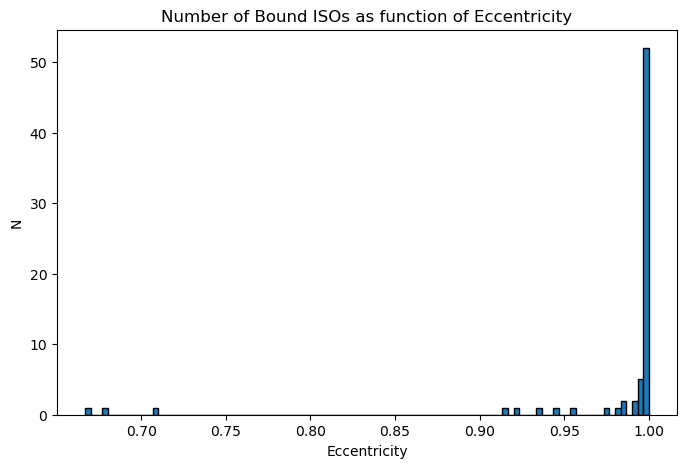

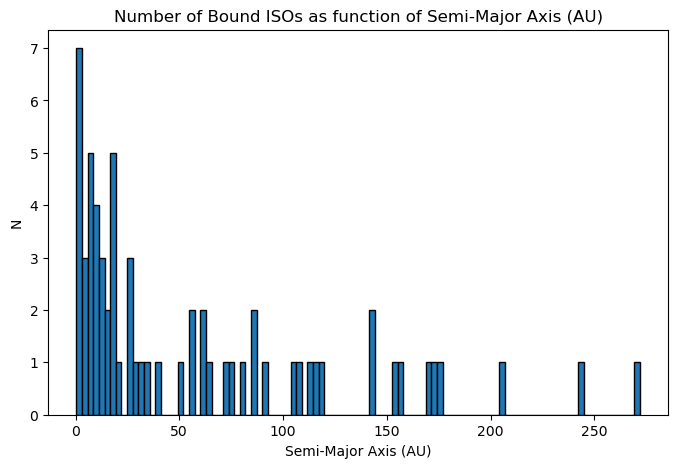

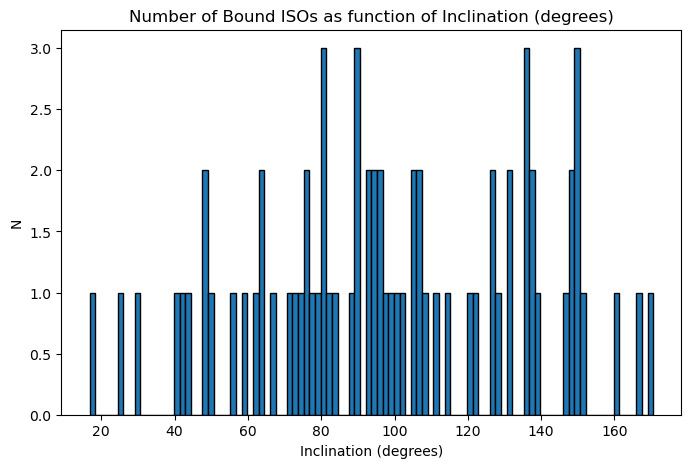

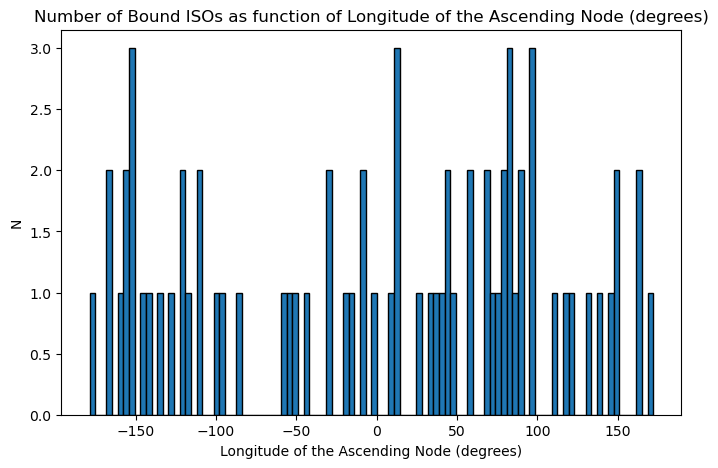

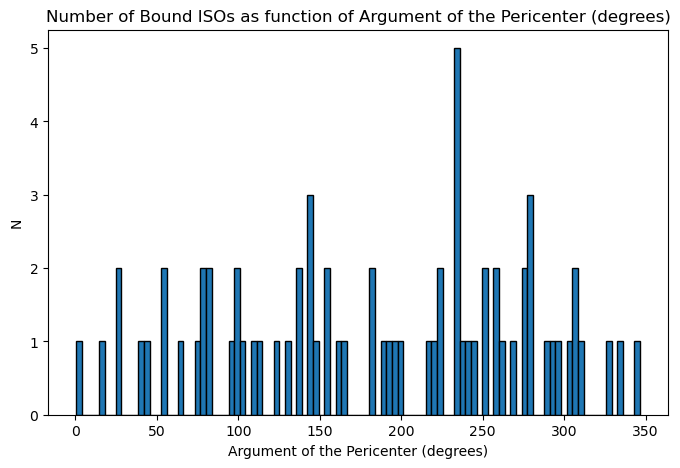

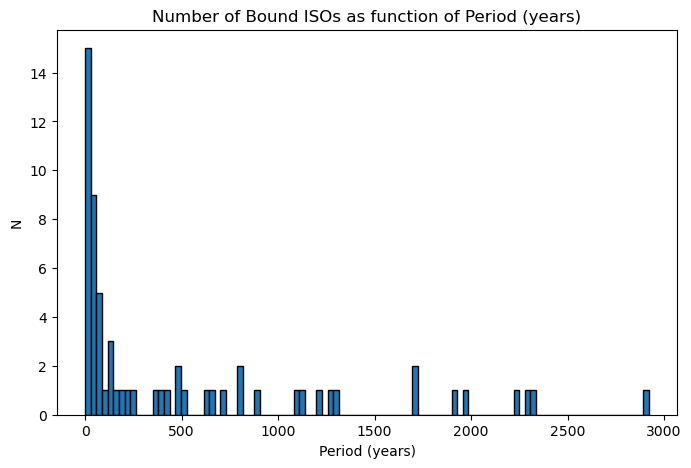

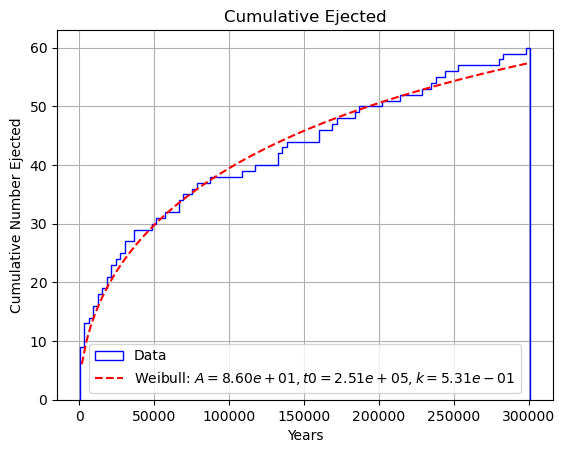

Approximate Current Number of Bound ISOs in Our Solar System Due to Hills Mechanism: 3.1147461690010187


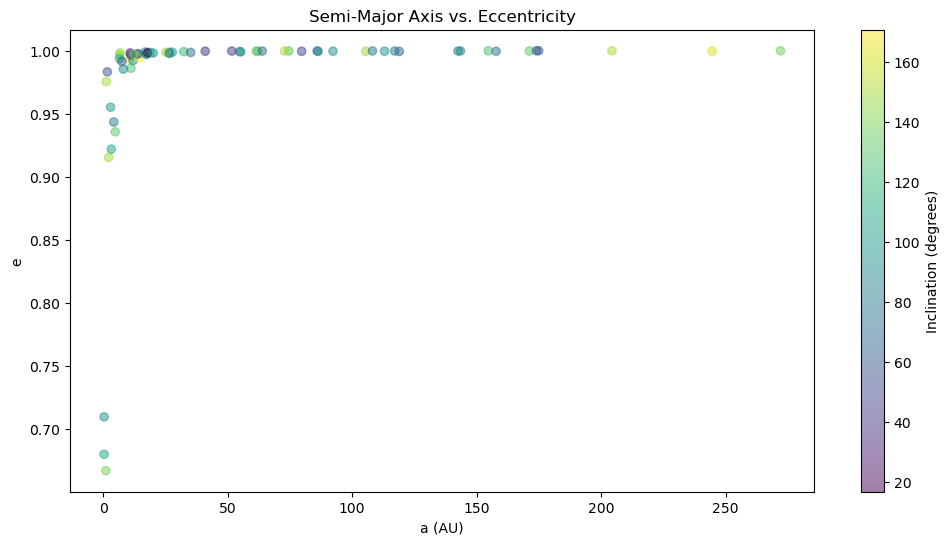

In [1]:
"""
*******************************************************************
BINARY CAPTURE BY THE HILL'S MECHANISM FOR ISOs IN OUR SOLAR SYSTEM
*******************************************************************
By Rainer Marquardt-Demen
********
Imports:
********
-OS: Operating system, used to save to file
-UUID: Unique identifiers for saving to file
-REBOUND (RB): Main integrator and package for N-body simulations
-REBOUNDX (RBX): Additional forces, i.e. outgassing, radiation pressure, Yarkovsky effect, general relativity
-NUMPY (NP): Math
-MATPLOTLIB (PLT): Plotting
-TQDM: Progress Bars
-DATETIME: Folders always have unique timestamp
-GC: Garbage collection for manual memory clean-up
-DASK: Parallel processing, requires Client, as_completed, LocalCluster, and deque
"""
import os
import uuid
import rebound as rb
import reboundx as rbx
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime
from scipy.optimize import curve_fit
from scipy.special import gammaincc
import gc
import dask
from dask.distributed import Client, as_completed, LocalCluster
from collections import deque
cluster = LocalCluster(
    dashboard_address=":8778",
    n_workers=6,
    threads_per_worker=1,
    memory_limit='2.2GB' #may need to tweak depending on your specs
)
client = Client(cluster) #go to 
print(f"Dask client dashboard is available at: http://localhost:8778/")
"""
***************
Initialization:
***************
-No: # of particles to test
-BATCH_SIZE: # of particles in each batch
-T: Max capture time for CAPTURE section (yrs)
-MAX_LIFE: Time to simulate to in lifetime section
-R_MEAN: Parameter for log-normal distribution of binary separation (km) NOTE: Not the actual mean or variance, for log-normal
-R_VAR: Parameter for log-normal distribution of binary separation (km)
-RHO: Density of ISOs (Mj/km^3), assumption from asteroids in the solar system
-F: Free unitless parameter that accounts for the radii of binary objects relative to their separation 
-RTIDAL: Calculated tidal disruption radius (km), sep*(M_Sun/Mbinary)^(1/3)
-MAXR: Distance away that binaries start out from (approximately infinity for impact paramater) (km)
-V_MEAN: Parameter for log-normal distribution of velocity at infinity (km/s) NOTE: Not the actual mean or variance, for log-normal
-V_VAR: Parameter for log-normal distribution of velocity at infinity (km/s)
-V_MAXWELL: Parameter for 3-D Maxwell-Boltzmann distribution of velocity at infinity (km/s)
-BINARY: Ratio between binary to total interstellar objects
-NISO: Average number density of ISOs (binary ISOs) (n/km^3)
-C: Speed of light (km/s)
-LSTAR: Luminosity of star (write units here)
-ALBEDO: Albedo
-BETA: Ratio of radiation pressure to force of gravity
-ALPHA, ETA, K, M, RO, A1, A2, A3: Parameters for outgassing
-COL: Flag for turning on collisions
-RAD: Flag for radiation forces
-GAS: Flag for outgassing
-GR: Flag for General relativity
"""
gc.collect()
No=int(1e6) # of particles
batch_size = int(1e3)
T = -1 # Time for capture in years, set to -1 for adaptive
maxlife = -2
r_mean = 8.443841549 
r_var = 1.229
rho = (1.58e-15)
f = 1/50 #1/5, 1/10, 1/20, 1/50, 1/100, 1/200
Rtidal = (1/f) * (3*1047.57/(2*np.pi*rho))**(1/3)
maxr = 3*1.498e8
v_mean = 3.715
v_var = 0.624
binary = 0.1
niso=3.4e-26*binary
date = "2020-01-01 12:00"
M = 1047.57
c = 299792  
lstar = 1.989e-17  
albedo = 0.09
beta = 0.001

alpha = 0.1112620426
eta = 5.093
k = 4.6142
m = 2.15
ro = 419961233.7
A1 = 1.846e-13
A2 = -6.388e-15
A3 = 4.297e-14

col=True 
rad = True
gas = True
gr = True

if col:
    def collisionfunc(sim_pointer, collision):
        sim = sim_pointer.contents # get simulation object from pointer
        if sim.particles[collision.p1]==sim.particles["Sun"]:
            return 2
        elif sim.particles[collision.p2]==sim.particles["Sun"]:
            return 1
        else:
            return 0

def init_dist(values, I):
    num_bins = 100
    Q1 = np.percentile(values, 10)
    Q3 = np.percentile(values, 90)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    values = [x for x in values if lower_bound <= x <= upper_bound]
    bins = np.linspace(min(values), max(values), num_bins + 1)
    counts, bin_edges = np.histogram(values, bins=bins)
    plt.figure(figsize=(8, 5))
    plt.bar(bin_edges[:-1], counts, width=np.diff(bin_edges), edgecolor='black', align='edge', label='Actual')
    x = np.linspace(1, max(values), 1000)
    if I=='Velocity (km/s)':
        k = 'Velocity (km/s)'
        pdf = max(values)/100 *No/(x*v_var*np.sqrt(2*np.pi)) * np.e**(-((np.log(x)-v_mean)**2)/(2*(v_var)**2))
    else:
        k = 'Binary Separation (km)'
        pdf = max(values)/100 *No/(x*r_var*np.sqrt(2*np.pi)) * np.e**(-((np.log(x)-r_mean)**2)/(2*(r_var)**2)) 
    plt.plot(x, pdf, color='r', linestyle='-', label='PDF')
    plt.xlabel(f'{k}')
    plt.ylabel('N')
    plt.title(f'Initial Distribution of {k}')
    plt.legend()
    plt.show()

def orbital_prop_plot(values, I, taper, theory):
    num_bins = 100
    if theory is None:
        if taper:
            Q1 = np.percentile(values, 25)
            Q3 = np.percentile(values, 75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            values = [x for x in values if x <= upper_bound]
        bins = np.linspace(min(values), max(values), num_bins + 1)
        counts, bin_edges = np.histogram(values, bins=bins)
        plt.figure(figsize=(8, 5))
        plt.bar(bin_edges[:-1], counts, width=np.diff(bin_edges), edgecolor='black', align='edge')
        plt.xlabel(f'{I}')
        plt.ylabel('N')
        plt.title(f'Number of Bound ISOs as function of {I}')
        plt.show()
    else:
        if taper:
            Q1 = np.percentile(values, 25)
            Q3 = np.percentile(values, 75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            theory = [x for x in theory if x <= upper_bound]
            values = [x for x in values if x <= upper_bound]
        bins = np.linspace(min(values), max(values), num_bins + 1)
        counts, bin_edges = np.histogram(values, bins=bins)
        counts1, bin_edges1 = np.histogram(theory, bins=bins)
        area_h1 = np.sum(counts1 * np.diff(bins))
        area_h2 = np.sum(counts * np.diff(bins))
        counts1 = counts1 * (area_h2 / area_h1)
        plt.figure(figsize=(8, 5))
        plt.bar(bin_edges[:-1], counts, width=np.diff(bin_edges), edgecolor='black', align='edge', alpha = 0.5, label="Actual")
        plt.bar(bin_edges[:-1], counts1, width=np.diff(bin_edges), edgecolor='black', align='edge', alpha = 0.5, label="Theory")
        plt.xlabel(f'{I}')
        plt.ylabel('N')
        plt.title(f'Number of Bound ISOs as function of {I}')
        plt.show()
            
np.random.seed(42) #reproducability
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
results_binary_folder = f"results_{timestamp}"
results_life_binary_folder = f"results_life{timestamp}"
os.makedirs(results_binary_folder, exist_ok=True)
os.makedirs(results_life_binary_folder, exist_ok=True)

temp=rb.Simulation()
temp.units = ('s', 'km', 'mjupiter')
G = temp.G
temp.add("Sun",date=date)
temp.add("Jupiter",date=date)
temp.add("Saturn", date=date)
temp.add("Uranus", date=date)
temp.add("Neptune", date=date)
temp.move_to_hel()
xJ=temp.particles[1].x
yJ=temp.particles[1].y
zJ=temp.particles[1].z
vxJ=temp.particles[1].vx
vyJ=temp.particles[1].vy
vzJ=temp.particles[1].vz
xS=temp.particles[2].x
yS=temp.particles[2].y
zS=temp.particles[2].z
vxS=temp.particles[2].vx
vyS=temp.particles[2].vy
vzS=temp.particles[2].vz
xU=temp.particles[3].x
yU=temp.particles[3].y
zU=temp.particles[3].z
vxU=temp.particles[3].vx
vyU=temp.particles[3].vy
vzU=temp.particles[3].vz
xN=temp.particles[4].x
yN=temp.particles[4].y
zN=temp.particles[4].z
vxN=temp.particles[4].vx
vyN=temp.particles[4].vy
vzN=temp.particles[4].vz
del temp
"""
********
Capture:
-RBDIST: Radial separation of binaries, based on Kuiper belt distribution of binaries
-VDIST: Velocity distribution, from local stellar velocity distribution
-MTOTDIST: Total mass of binary (a function of RBDIST)
-VNEWDIST: Energy conservation
-VORBITDIST: Linear velocity of binaries due to their mutual attraction (function of rbdist)
-THETA0DIST, PHI0DIST: Position vector of binaries
-QDIST: Phase of binary orbit
-Q1DIST, IMPACT1DIST: Velocity vector of bulk
-GAM, BE: Position vector of bulk
********
"""
rbdist = np.random.lognormal(mean=r_mean, sigma=r_var, size=No)
vdist = np.random.lognormal(mean=v_mean, sigma=v_var, size=No)
countinitv = init_dist(vdist,'Velocity (km/s)')
countinitv = init_dist(rbdist,'Binary Separation (km)')
thetas = np.arctan(2*Rtidal/maxr)
impact = np.arccos(np.random.uniform(np.cos(thetas),1, size=No))
minr = maxr*np.sin(impact)/(G*M/(maxr*np.sin(impact)*vdist**2)+np.sqrt((G*M/(maxr*np.sin(impact)*vdist**2))**2 + 1))
E = (1/2)*(vdist**2) - (4*G*M*rbdist)/(Rtidal**2) 
thbound = 0
for i in range(No):
    if minr[i]>(696340) and E[i]<0:
        thbound+=1
ratio = (thbound/No)
print(f'Approximate number bound: {int(ratio*No)}, or ratio: {ratio}')
del E, minr, thbound
 #???
#vt = np.sqrt(vdist**2 + 2*G*1047.57/rT)
#L = (1/2)*mtotdist*vt*rT-(mtotdist/2)*(rbdist*vt + rT*2*vb)
#eccentricity = np.sqrt(1+(2*E*L**2)/(mtotdist**3 * (1/8) * G**2 * 1047.57**2))
#eccentricity = [x for x in eccentricity if x<1]
#theoretical_a = -(G * 1047.57 * (mtotdist/2) * 1.496e-8)/E
#theoretical_a = [x for x in theoretical_a if x>0]
vesc = np.sqrt(2*G*1047.57/maxr)
#ratioe = len(eccentricity)/No
gc.collect()
def simulate_particle(v, r, impact, col=col,
                      collisionfunc=collisionfunc, vesc=vesc, maxr=maxr, f=f, T=T, thetas=thetas, c=c):
    sim = rb.Simulation()
    collide = False
    sim.units=('s', 'km', 'mjupiter')
    sim.add(m=1047.57, r=696340, hash="Sun")
    if col:
        sim.collision = "direct"
        sim.collision_resolve = collisionfunc
    result = None
    vnew = np.sqrt(v**2 + 2*G*1047.57/maxr)
    mtot = (8/3) * np.pi*rho*(f*r)**3
    vorbit = np.sqrt(G*mtot/(4*r))
    sim.ri_ias15.min_dt = (np.pi*r)/(vorbit*1e5)
    theta0 = np.arccos(1 - 2 * np.random.uniform(0, 1))
    phi0 = np.random.uniform(0, 2 * np.pi)
    #first we intitalize the binary position vectors
    x0, y0, z0 = ((np.sin(theta0)* np.cos(phi0)),
            (np.sin(theta0) * np.sin(phi0)),
            (np.cos(theta0)))
    pos_vec = np.array([x0, y0, z0])
    arbitrary_vec = np.array([0, 0, 1]) if not np.isclose(pos_vec[2], 1) else np.array([0, 1, 0])
    perp_vec1 = arbitrary_vec - np.dot(arbitrary_vec, pos_vec) * pos_vec
    perp_vec1 /= np.linalg.norm(perp_vec1)
    perp_vec2 = np.cross(pos_vec, perp_vec1)
    q = np.random.uniform(0, 2 * np.pi)
    xrad,yrad,zrad = ((r/2)*np.cos(q) * perp_vec1 + (r/2)*np.sin(q) * perp_vec2)
    #binary velocity vectors
    velvector = np.array([2*xrad/r,2*yrad/r,2*zrad/r])
    vel = np.cross(velvector, pos_vec)
    vel/=np.linalg.norm(vel)
    vel1=[vorbit*x for x in vel]
    #bulk position vectors
    q1 = np.random.uniform(0, 2 * np.pi)
    gam1 = np.random.uniform(0, 2 * np.pi)
    be1 = np.arccos(1 - 2 * np.random.uniform(0, 1))
    position = np.array([np.cos(gam1)*np.sin(be1), np.sin(gam1)*np.sin(be1), np.cos(be1)])
    #bulk velocity vectors
    arbitrary_vec1 = np.array([0, 0, 1]) if not np.isclose(position[2], 1) else np.array([0, 1, 0])
    perp_vec11 = arbitrary_vec1 - np.dot(arbitrary_vec1, position) * position
    perp_vec11 /= np.linalg.norm(perp_vec11)
    perp_vec21 = np.cross(position, perp_vec11)
    veloc = (vnew*np.cos(q1)*np.sin(impact)*perp_vec11 + vnew*np.sin(q1)*np.sin(impact)*perp_vec21 + vnew*np.cos(impact)*position)
        
    x0,y0,z0=xrad+maxr*position[0],yrad+maxr*position[1],zrad+maxr*position[2]
    x1,y1,z1=-xrad+maxr*position[0],-yrad+maxr*position[1],-zrad+maxr*position[2]
        
    v0x, v0y, v0z= vel1[0]-veloc[0], vel1[1]-veloc[1], vel1[2]-veloc[2]
    v1x, v1y, v1z= -vel1[0]-veloc[0], -vel1[1]-veloc[1], -vel1[2]-veloc[2]
        
    sim.add(x=x0, y=y0, z=z0,  m=mtot/2, r=r*f, vx= v0x, vy= v0y, vz= v0z, hash="ISO 1")
    sim.add(x=x1, y=y1, z=z1,  m=mtot/2, r=r*f, vx= v1x, vy= v1y, vz= v1z, hash="ISO 2")
    sim.move_to_hel()
    if T==-1:
        T=10*np.sqrt(maxr**2 + (np.sin(impact)*maxr)**2)/(vnew*365.25*86400)
    sim.integrate(T*365.25*86400)
    if sim.N==1:
        result={"collide":True}
        pass
    elif sim.N==2:
        collide=True
        if sim.particles[1].orbit(primary=sim.particles["Sun"]).e<1 and (0.5*((sim.particles[1].vx)**2 + (sim.particles[1].vy)**2 + (sim.particles[1].vz)**2) - sim.G*1047.57/(sim.particles[1]**sim.particles["Sun"]))<0:
                
            x=sim.particles[1].x
            y=sim.particles[1].y
            z=sim.particles[1].z
            vx=sim.particles[1].vx
            vy=sim.particles[1].vy
            vz=sim.particles[1].vz
            result = {
                    "r":r,
                    "v":v,
                    "x":x,
                    "y":y,
                    "z":z,
                    "vx":vx,
                    "vy":vy,
                    "vz":vz,
                    "collide":True
                }
    elif sim.N==3:
        for i in [1, 2]:
            p = sim.particles[i]
            orb = p.orbit(primary=sim.particles["Sun"])
            rel_dist = sim.particles[1] ** sim.particles[2]
            sun_dist = p**sim.particles["Sun"]
            energy = 0.5 * (p.vx**2 + p.vy**2 + p.vz**2) - sim.G * 1047.57 / sun_dist
    
            if orb.e < 1 and energy < 0 and rel_dist > 1e6:
                if result is None or sun_dist < result["a"]:  # prefer tighter capture
                    result = {
                            "r": r,
                            "v": v,
                            "x": p.x, "y": p.y, "z": p.z,
                            "vx": p.vx, "vy": p.vy, "vz": p.vz,
                            "a": sun_dist, "collide":False
                        }
    del sim
    return result

"""
********************
Parallel Processing:
********************
Partition into batches and submit to dask as a futures.
"""
def simulate_batch(batch_array):
    filtered_results = []
    for row in batch_array:
        result = simulate_particle(*map(float, row))
        if result:
            filtered_results.append(result)
    # Save this filtered batch directly (each Dask worker does it)
    if filtered_results:  # Only save non-empty
        result_id = uuid.uuid4().hex
        result_path = f"{results_binary_folder}/batch_{result_id}.npz"
        np.savez_compressed(result_path, results=filtered_results)
        return result_path  # Return path for later streaming
    else:
        return None
    
all_particles_args = np.array(list(zip(vdist, rbdist, impact)))
batches = [all_particles_args[i:i+batch_size] for i in range(0, len(all_particles_args), batch_size)]
del all_particles_args, vdist, rbdist, impact
max_in_flight = 7  # Set to num workers or slightly more
result_paths = []
futures = deque()
ac = as_completed()

# Submit initial batch
batch_iter = iter(batches)
for _ in range(max_in_flight):
    try:
        batch = next(batch_iter)
        future = client.submit(simulate_batch, batch)
        ac.add(future)
        futures.append(future)
    except StopIteration:
        break

# Now process completed ones and submit new ones to keep pool full
for completed in tqdm(ac, total=len(batches)):
    try:
        result_path = completed.result()
        if result_path:  # Only keep if not None
            result_paths.append(result_path)
            del result_path
    except Exception as e:
        print(f"Error in batch: {e}")

    # Always try to maintain max_in_flight tasks
    try:
        batch = next(batch_iter)
        future = client.submit(simulate_batch, batch)
        ac.add(future)
        futures.append(future)
    except StopIteration:
        continue
colliden=0
nobound = 0
x_bound  = []
y_bound  = []
z_bound  = []
vx_bound = []
vy_bound = []
vz_bound = []
v_bound = []
r_bound = []
#post-processing data
for path in tqdm(result_paths):
    with np.load(path, allow_pickle=True) as data:
        batch = data["results"]
        for particle in batch:
            if particle["collide"] is True:
                colliden+=1
            if particle.get("r"):
                nobound+=1
                x_bound.append(particle["x"])
                y_bound.append(particle["y"])
                z_bound.append(particle["z"])
                vx_bound.append(particle["vx"])
                vy_bound.append(particle["vy"])
                vz_bound.append(particle["vz"])
                v_bound.append(particle["v"])
                r_bound.append(particle["r"])
            del particle
    del batch, data

del result_paths, batches
print(f'Actual Number collided: {colliden}')
  
avgv = np.exp(v_mean + (v_var**2)/2) #we take the average directly from distribution to save memory, possibly need to change?

caprate = (4*np.pi*(maxr)**2 * avgv * ((1-np.cos(np.arctan(2*Rtidal/maxr)))/2) * niso * (nobound/No) * 365.25 * 86400)**(-1)
#calculated by taking surface area (4pir^2), times flux (avgv*niso), times probability of v vector (((1-np.cos(np.arctan(Rtidal/maxr))/2)
#times probability of capture (nobound/noiso)
print(f'Number of bound: {nobound}/{No} or {nobound/No}, 1 bound ISO in {caprate} years, Theoretical fraction bound: {ratio}')
print(f'Accuracy: {(1-np.abs(((nobound/No)-ratio)/(nobound/No)))*100}')
gc.collect()

boundrdist = orbital_prop_plot(r_bound, "R Bound (km)", True, None)
boundvdist = orbital_prop_plot(v_bound, "V Bound (km/s)", True, None)

if maxlife<0:
    maxlife=(maxlife*(-1)*caprate)

def life_simulate(x_bound, y_bound, z_bound, vx_bound, vy_bound, vz_bound, r_bound, rad=rad, c=c, lstar=lstar, alpha=alpha, eta=eta, m=m, k=k, ro=ro, 
                  A1=A1, A2=A2, A3=A3, col=col, collisionfunc=collisionfunc, rho=rho, albedo=albedo, beta=beta, f=f, xJ=xJ,
                 yJ=yJ, zJ=zJ, vxJ=vxJ, vyJ=vyJ, vzJ=vzJ, xS=xS,yS=yS,zS=zS,vxS=vxS,vyS=vyS,
                vzS=vzS,xU=xU,yU=yU,zU=zU,vxU=vxU,vyU=vyU,vzU=vzU,xN=xN,yN=yN,zN=zN,vxN=vxN,vyN=vyN,vzN=vzN, capate=caprate):
    life = rb.Simulation()
    life.units = ('s', 'km', 'mjupiter')
    life.ri_ias15.min_dt = 1e1
    rebx = rbx.Extras(life)
    avglife = None
    bounde = None
    bounda = None
    boundP = None
    boundinc = None
    boundOmega = None
    boundomega = None
    long = False
    
    if rad:
        yark = rebx.load_force("yarkovsky_effect")
        yark.params["ye_c"] = c
        yark.params["ye_lstar"] = lstar 
        rebx.add_force(yark)
        
        rf = rebx.load_force("radiation_forces")
        rf.params["c"] = c
        rebx.add_force(rf)

    if gas:
        outgas = rebx.load_force("outgas")
        outgas.params["alpha"] = alpha
        outgas.params["n"] = eta
        outgas.params["m"] = m
        outgas.params["k"] = k
        outgas.params["r0"] = ro
        outgas.params["a01"] = A1
        outgas.params["a02"] = A2
        outgas.params["a03"] = A3
        rebx.add_force(outgas)

    if gr: 
        gr_force = rebx.load_force("gr_potential")
        rebx.add_force(gr_force)
        gr_force.params["c"] = c

    if col:
        life.collision = "direct"
        life.collision_resolve = collisionfunc

    life.add(m=1047.57, r=696340, hash="Sun")
    life.add(m=1, r=69911, x=xJ, y=yJ, z=zJ, vx=vxJ, vy=vyJ, vz=vzJ, hash="Jupiter")
    life.add(x=xS, 
            y=yS,  
            z=zS, 
            vx=vxS, 
            vy=vyS, 
            vz=vzS, 
            m=0.3,
            r=58233,
            hash="Saturn")
    life.add(x=xU, 
            y=yU,  
            z=zU, 
            vx=vxU, 
            vy=vyU, 
            vz=vzU, 
            m=0.0457,
            r=25362,
            hash="Uranus")
    life.add(x=xN, 
            y=yN,  
            z=zN, 
            vx=vxN, 
            vy=vyN, 
            vz=vzN, 
            m=0.054,
            r=24622,
            hash="Neptune")
    life.add(x=x_bound,y=y_bound,z=z_bound,vx=vx_bound,vy=vy_bound,vz=vz_bound,r=(r_bound*f), hash="ISO")
    life.move_to_hel()
    life.N_active = 5
    
    if rad:
        inout =[-1,1]
        life.particles["ISO"].params["ye_flag"] = np.random.choice(inout)
        life.particles["ISO"].params["ye_body_density"] = rho
        life.particles["ISO"].params["ye_albedo"] = albedo
        life.particles["ISO"].params["beta"] = beta


    for j in range(int(maxlife)):
        life.integrate(life.t+365.25*86400)  
        if life.N==5:
            avglife=(j)
            break
        elif life.particles["ISO"].orbit(primary=life.particles["Sun"]).e>=1:
            avglife=(j)
            break 
        elif j==int(1000):
            orb = life.particles["ISO"].orbit(primary=life.particles["Sun"])
            bounde = orb.e
            bounda = orb.a
            boundP = orb.P
            boundinc = orb.inc
            boundOmega = orb.Omega
            boundomega = orb.omega
    del life, rebx

    result = {
        "e": bounde, "a": bounda, "P": boundP,
        "inc": boundinc, "Omega": boundOmega, "omega": boundomega,"avglife": avglife
        }
    return result

def simulate_life_batch(batch_array):
    filtered_results = []
    for row in batch_array:
        result = life_simulate(*map(float, row))  # Only save if it's a captured ISO
        filtered_results.append(result)
    result_id = uuid.uuid4().hex
    result_path = f"{results_life_binary_folder}/batch_{result_id}.npz"
    np.savez_compressed(result_path, results=filtered_results)
    return result_path  # Return path for later streaming

all_particles_args = np.array(list(zip(x_bound, y_bound, z_bound, vx_bound, vy_bound, vz_bound, r_bound)))
batches = [all_particles_args[i:i+int(nobound/20)] for i in range(0, len(all_particles_args), int(nobound/20))]

max_in_flight = 7  # Set to num workers or slightly more
result_paths_life = []
futures = deque()
ac = as_completed()

# Submit initial batch
batch_iter = iter(batches)
for _ in range(max_in_flight):
    try:
        batch = next(batch_iter)
        future = client.submit(simulate_life_batch, batch)
        ac.add(future)
        futures.append(future)
    except StopIteration:
        break

# Now process completed ones and submit new ones to keep pool full
for completed in tqdm(ac, total=len(batches)):
    try:
        result_path = completed.result()
        if result_path:  # Only keep if not None
            result_paths_life.append(result_path)
            del result_path
    except Exception as e:
        print(f"Error in batch: {e}")

    # Always try to maintain max_in_flight tasks
    try:
        batch = next(batch_iter)
        future = client.submit(simulate_life_batch, batch)
        ac.add(future)
        futures.append(future)
    except StopIteration:
        continue

long=0
e_bound = []
P_bound = []
inc_bound = []
omega_bound = []
Omega_bound = []
a_bound = []
ejected = []

for path in tqdm(result_paths_life):
    with np.load(path, allow_pickle=True) as data:
        batch = data["results"]
        for particle in batch:
            if particle["avglife"] is not None:
                if particle["avglife"]>(10000):
                    e_bound.append(particle["e"])
                    P_bound.append(particle["P"])
                    inc_bound.append(particle["inc"])
                    omega_bound.append(particle["omega"])
                    Omega_bound.append(particle["Omega"])
                    a_bound.append(particle["a"])
                    ejected.append(particle["avglife"])
                else:
                    ejected.append(particle["avglife"])
            else:
                e_bound.append(particle["e"])
                P_bound.append(particle["P"])
                inc_bound.append(particle["inc"])
                omega_bound.append(particle["omega"])
                Omega_bound.append(particle["Omega"])
                a_bound.append(particle["a"])
del result_paths_life


def ecc_a_inc(e,a, inc):
    plt.rcParams['figure.figsize'] = [12, 6]
    newa=[]
    newe=[]
    newinc=[]
    for i in range(len(a)):
        if a[i]<300:
            newa.append(a[i])
            newe.append(e[i])
            newinc.append(inc[i])
        else:
            continue
    scatter = plt.scatter(newa, newe, c=newinc, cmap='viridis', marker='o', alpha=0.5)
    plt.colorbar(scatter, label='Inclination (degrees)') 
    plt.title('Semi-Major Axis vs. Eccentricity')
    plt.xlabel('a (AU)')
    plt.ylabel('e')
    plt.show()

def lin_fit(t, B0, B1, A=nobound):
    return A*(1-np.exp(-(t/B0)**B1))

def ejected_plot(values, nobound=nobound):
    # Generate cumulative histogram data
    counts, bin_edges = np.histogram(values, bins=100)
    cumulative_counts = np.cumsum(counts)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    
    # Fit the function A*t + B
    try:
        popt, _ = curve_fit(lin_fit, bin_centers, cumulative_counts, p0=[1e5, 1], maxfev=2147483646)
        B0_fit, B1_fit = popt[0], popt[1]
        fit_values = lin_fit(bin_centers, B0_fit, B1_fit)
    except RuntimeError:
        B0_fit = None
        B1_fit = None
        fit_values = None

    # Plot cumulative histogram
    plt.hist(values, bins=100, cumulative=True, density=False, histtype='step', color='blue', label='Data')

    # Plot linear fit if successful
    if fit_values is not None:
        label = fr'Weibull: $A = {nobound:.2e}, t0 = {B0_fit:.2e}, k = {B1_fit:.2e}$'
        plt.plot(bin_centers, fit_values, 'r--', label=label)

    # Labels and styling
    plt.xlabel('Years')
    plt.ylabel('Cumulative Number Ejected')
    plt.title('Cumulative Ejected')
    plt.legend()
    plt.grid(True)
    plt.show()
    return B0_fit, B1_fit
    
a_bound[:] = [x / 1.496e8 for x in a_bound]
P_bound[:] = [x / 31557600 for x in P_bound]
inc_bound[:] = [x * (180/np.pi) for x in inc_bound]
Omega_bound[:] = [x * (180/np.pi) for x in Omega_bound]
omega_bound[:] = [x * (180/np.pi) for x in omega_bound]

edist = orbital_prop_plot(e_bound, "Eccentricity", False, None)
adist = orbital_prop_plot(a_bound, "Semi-Major Axis (AU)", True, None)
incdist = orbital_prop_plot(inc_bound, "Inclination (degrees)", False, None)
Omegadist = orbital_prop_plot(Omega_bound, "Longitude of the Ascending Node (degrees)", False, None)
omegadist = orbital_prop_plot(omega_bound, "Argument of the Pericenter (degrees)", False, None)
Pdist = orbital_prop_plot(P_bound, "Period (years)", True, None)
if len(ejected) !=0:
    B0fit, B1fit = ejected_plot(ejected) 
    steady = (-(caprate**(-1))*B0fit*gammaincc(1/B1fit, (4.5e9/B0fit)**B1fit)/B1fit) + ((caprate**(-1))*B0fit*gammaincc(1/B1fit, 0)/B1fit)
    print(f'Approximate Current Number of Bound ISOs in Our Solar System Due to Hills Mechanism: {steady}')
scatterplt = ecc_a_inc(e_bound,a_bound, inc_bound)

## 